## TerrainMesh: Metric-Semantic Terrain Reconstruction from Aerial Images Using Joint 2D-3D Learning

### Load and visualize the demo data

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


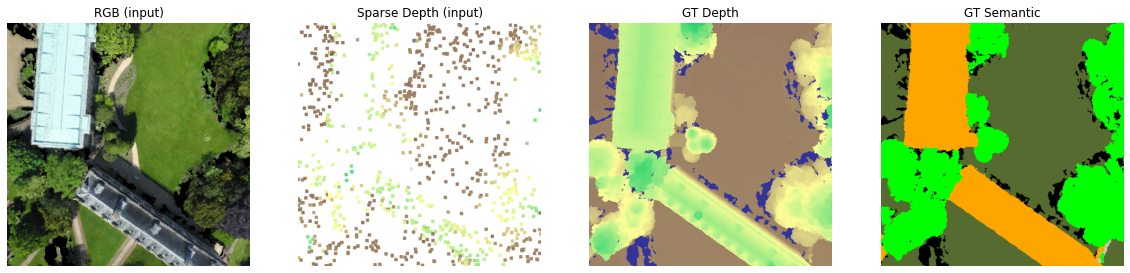

In [1]:
%matplotlib inline
from imageio import imread
import matplotlib.pyplot as plt
from utils.semantic_labels import convert_class_to_rgb_sensat_simplified 
from vis.vis import pseudo_color_map, pseudo_color_map_sparse

rgb_file = "demo_data/RGB.png"
sparse_depth_file = "demo_data/SparseDepth.png"
gt_depth_file = "demo_data/GT_Depth.png"
gt_sem_file = "demo_data/GT_Semantics.png"

depth_scale = 100
depth_min = 40
depth_max = 90

# Visualize the input data and the groundtruth
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,5))
rgb = imread(rgb_file) 
ax1.imshow(rgb)
ax1.set_title('RGB (input)')
ax1.axis('off')
sparsedepth = imread(sparse_depth_file)/depth_scale 
sparsedepth_vis = pseudo_color_map_sparse(sparsedepth,depth_min,depth_max)
ax2.imshow(sparsedepth_vis)
ax2.set_title('Sparse Depth (input)')
ax2.axis('off')
gt_depth = imread(gt_depth_file)/depth_scale
gt_depth_vis = pseudo_color_map(gt_depth,depth_min,depth_max)
ax3.imshow(gt_depth_vis)
ax3.set_title('GT Depth')
ax3.axis('off')
gt_sem = imread(gt_sem_file)
gt_sem_vis = convert_class_to_rgb_sensat_simplified(gt_sem)
ax4.imshow(gt_sem_vis)
ax4.set_title('GT Semantic')
ax4.axis('off')
plt.show()

### Get the 2D segmentation

Using cache found in /home/qiaojun/.cache/torch/hub/pytorch_vision_v0.8.0


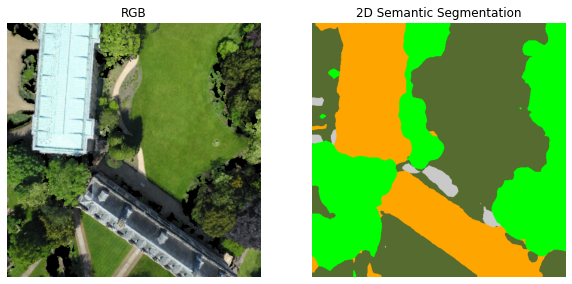

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from config import get_sensat_cfg

save_model_path = "checkpoints/deeplab/model_best_semantic.tar"
cfg_file = "Sensat_basic.yaml"

cfg = get_sensat_cfg()
cfg.merge_from_file(cfg_file)

# Load a trained deeplabv3 2D semantic segmentation model
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model_2dseg = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet50', pretrained=True)
model_2dseg.classifier[4] = nn.Conv2d(256, cfg.MODEL.DEEPLAB.NUM_CLASSES, kernel_size=1, stride=1)
model_2dseg.to(device)
checkpoint = torch.load(save_model_path)
model_2dseg.load_state_dict(checkpoint["model_state_dict"])
model_2dseg.eval()

# The input is an RGB image
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(rgb)
input_img = input_tensor.unsqueeze(0).to(device)
pred_semantic_features = model_2dseg(input_img)["out"]
pred_semantic = pred_semantic_features.detach().max(dim=1)[1].cpu().numpy()[0,::]
pred_semantic_vis = convert_class_to_rgb_sensat_simplified(pred_semantic)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(rgb)
ax1.set_title('RGB')
ax1.axis('off')
ax2.imshow(pred_semantic_vis)
ax2.set_title('2D Semantic Segmentation')
ax2.axis('off')
plt.show()

## Mesh initialization using sparse depth measurements

Mesh Initialization Time:  0.11555027961730957


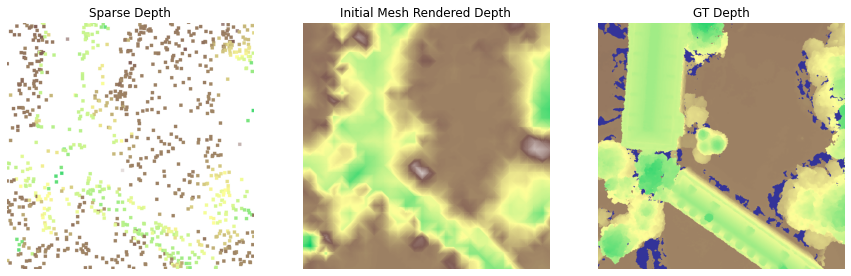

/home/qiaojun/.local/lib/python3.8/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.1395301…

In [3]:
import meshplot as mp
import numpy as np 
from mesh_init.mesh_init_linear_solver import init_mesh_sparse
from mesh_init.mesh_renderer import mesh_render_depth
from pytorch3d.structures import Meshes
from vis.vis import texture_mesh_vertices
import time

num_mesh_vertices = 1024
image_size = 512
focal_length = -2
depth_min = 40
depth_max = 90

# Initialize the mesh using only the sparse depth
start_time = time.time()
init_mesh_vertices, init_mesh_faces = init_mesh_sparse(sparsedepth,num_mesh_vertices,w_laplacian=0.5)
end_time = time.time()
print("Mesh Initialization Time: ", end_time-start_time)
init_mesh_vertices_tensor = torch.tensor(init_mesh_vertices,dtype=torch.float32,device=device)
init_mesh_faces_tensor = torch.tensor(init_mesh_faces,dtype=torch.int32,device=device)
init_mesh = Meshes(verts=[init_mesh_vertices_tensor], faces=[init_mesh_faces_tensor])

init_mesh_depth = mesh_render_depth(init_mesh,image_size=image_size,focal_length=focal_length)
init_mesh_depth_vis = pseudo_color_map(init_mesh_depth,depth_min,depth_max)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.imshow(sparsedepth_vis)
ax1.set_title('Sparse Depth')
ax1.axis('off')
ax2.imshow(init_mesh_depth_vis)
ax2.set_title('Initial Mesh Rendered Depth')
ax2.axis('off')
ax3.imshow(gt_depth_vis)
ax3.set_title('GT Depth')
ax3.axis('off')
plt.show()

init_mesh_height_color = texture_mesh_vertices(init_mesh_vertices, depth_min, depth_max)
rotate_matrix = np.array([[1,0,0],[0,-np.sqrt(3)/2,1/2],[0,-1/2,-np.sqrt(3)/2]])
mp.plot(init_mesh_vertices@rotate_matrix, init_mesh_faces, init_mesh_height_color)

## Mesh refinement

In [4]:
import os
from pytorch3d.structures import Meshes
from scipy import ndimage
from torchvision import transforms
from config import get_sensat_cfg
from model.models import VoxMeshHead
import time

save_model_path = "checkpoints/Sem_Dice/model_best_depth.tar"
depth_scale = 100
device = torch.device("cuda:0")

# Load a trained 2D-3D model for mesh refinement
cfg = get_sensat_cfg()
cfg.merge_from_file(os.path.join(save_model_path,"..","Sensat_basic.yaml"))
model = VoxMeshHead(cfg)
checkpoint = torch.load(save_model_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

# Combine the 2D inputs, including the RGB, the initial mesh rendered depth and the sparse depth EDT.
rgb_tensor = transforms.ToTensor()(rgb).unsqueeze(0).to(device)
init_mesh_depth_tensor = transforms.ToTensor()(init_mesh_depth/depth_scale).unsqueeze(0).to(device)
sparsedepth_mask = (sparsedepth<=0)*1
depth_edt = ndimage.distance_transform_edt(sparsedepth_mask)
depth_edt_tensor = transforms.ToTensor()(depth_edt).unsqueeze(0).to(device)
input_img = torch.cat((rgb_tensor, init_mesh_depth_tensor, depth_edt_tensor), dim=1).to(torch.float)

# Normalized the mesh
init_mesh_scale = torch.mean(init_mesh_vertices_tensor[:,2])
init_mesh_vertices_norm_tensor = init_mesh_vertices_tensor / init_mesh_scale
init_mesh = Meshes(verts=[init_mesh_vertices_norm_tensor], faces=[init_mesh_faces_tensor])

# The model takes in the concatenated 2D inputs, the initial mesh and the 2D semantic segmentation
start_time = time.time()
refine_mesh = model(input_img, init_mesh, pred_semantic_features)
refine_mesh = refine_mesh[1].scale_verts(init_mesh_scale.unsqueeze(0).to(device))

end_time = time.time()
print("Mesh Refinement Time: ", end_time-start_time)

Mesh Refinement Time:  0.012954473495483398


Visualize the refined mesh.

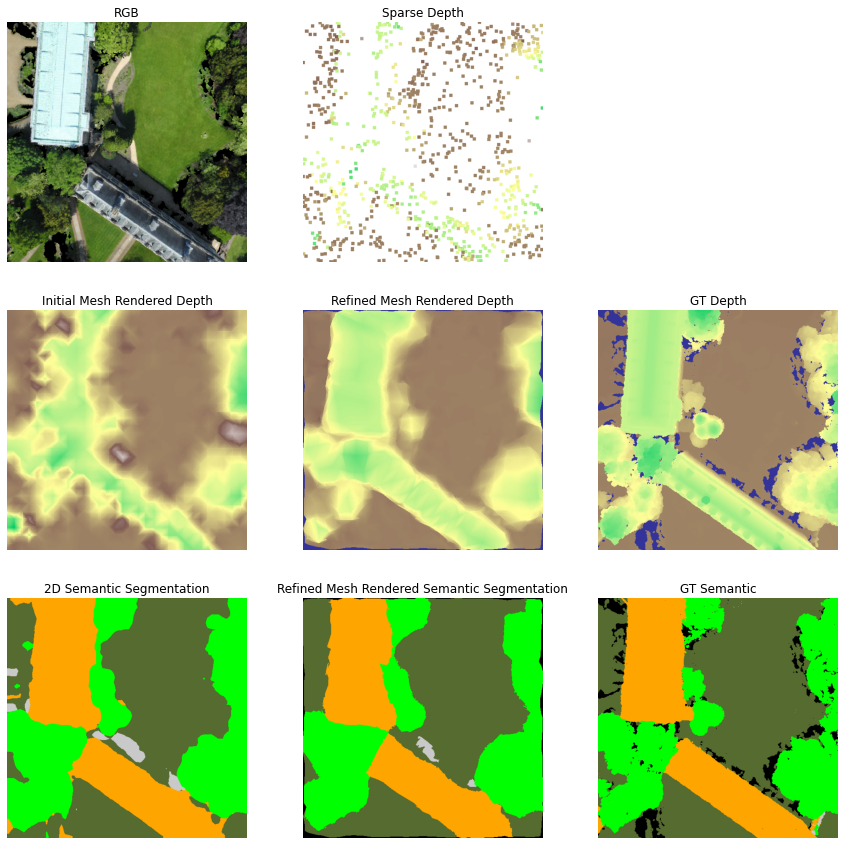

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.532943…

In [5]:
from mesh_init.mesh_renderer import render_mesh_texture
from utils.semantic_labels import convert_class_to_rgb_sensat_simplified 
from vis.vis import pseudo_color_map

device = torch.device("cuda:0")
depth_min = 40
depth_max = 90
image_size = 512
focal_length = -2

refine_mesh_semantic, refine_mesh_depth = render_mesh_texture(refine_mesh,image_size=image_size,focal_length=focal_length,device=device)
refine_mesh_semantic_vis = convert_class_to_rgb_sensat_simplified(refine_mesh_semantic)
refine_mesh_depth_vis = pseudo_color_map(refine_mesh_depth,depth_min,depth_max)

fig, ((ax11,ax12,ax13),(ax21,ax22,ax23),(ax31,ax32,ax33)) = plt.subplots(3,3,figsize=(15,15))

ax11.imshow(rgb)
ax11.set_title('RGB')
ax11.axis('off')
ax12.imshow(sparsedepth_vis)
ax12.set_title('Sparse Depth')
ax12.axis('off')
ax13.axis('off')

ax21.imshow(init_mesh_depth_vis)
ax21.set_title('Initial Mesh Rendered Depth')
ax21.axis('off')
ax22.imshow(refine_mesh_depth_vis)
ax22.set_title('Refined Mesh Rendered Depth')
ax22.axis('off')
ax23.imshow(gt_depth_vis)
ax23.set_title('GT Depth')
ax23.axis('off')

ax31.imshow(pred_semantic_vis)
ax31.set_title('2D Semantic Segmentation')
ax31.axis('off')
ax32.imshow(refine_mesh_semantic_vis)
ax32.set_title('Refined Mesh Rendered Semantic Segmentation')
ax32.axis('off')
ax33.imshow(gt_sem_vis)
ax33.set_title('GT Semantic')
ax33.axis('off')

plt.show()

refine_mesh_vertices, refine_mesh_faces = refine_mesh.get_mesh_verts_faces(0)
refine_mesh_vertices = refine_mesh_vertices.detach().cpu().numpy()
refine_mesh_faces = refine_mesh_faces.detach().cpu().numpy()
refine_mesh_height_color = texture_mesh_vertices(refine_mesh_vertices, depth_min, depth_max)
rotate_matrix = np.array([[1,0,0],[0,-np.sqrt(3)/2,1/2],[0,-1/2,-np.sqrt(3)/2]])
mp.plot(refine_mesh_vertices@rotate_matrix, refine_mesh_faces, refine_mesh_height_color)

## Save the refined mesh with different textures (Color, Elevation, Semantics)

You can visualize the saved meshes in other apps like [MeshLab](https://www.meshlab.net/) or [Open3D](http://www.open3d.org/).

In [6]:
import open3d as o3d
from vis.vis import texture_mesh

focal_length_texture = 2
refine_mesh_rgb_path = "demo_data/refined_mesh/refine_rgb.obj"
refine_mesh_depth_path = "demo_data/refined_mesh/refine_depth.obj"
refine_mesh_semantic_path = "demo_data/refined_mesh/refine_semantic.obj"

# Save the mesh in the Open3D TriangleMesh
refine_mesh_o3d = o3d.geometry.TriangleMesh()
refine_mesh_o3d.vertices = o3d.utility.Vector3dVector(refine_mesh_vertices)
refine_mesh_o3d.triangles = o3d.utility.Vector3iVector(refine_mesh_faces)
    
# RGB colors
refine_mesh_rgb = texture_mesh(rgb, refine_mesh_o3d, focal_length_texture)
o3d.io.write_triangle_mesh(refine_mesh_rgb_path,refine_mesh_rgb)

# Elevation/Depth
refine_mesh_depth = texture_mesh(refine_mesh_depth_vis, refine_mesh_o3d, focal_length_texture)
o3d.io.write_triangle_mesh(refine_mesh_depth_path,refine_mesh_depth)

# Semantic
refine_mesh_semantic = texture_mesh(refine_mesh_semantic_vis, refine_mesh_o3d, focal_length_texture)
o3d.io.write_triangle_mesh(refine_mesh_semantic_path,refine_mesh_semantic)


True